# 第5章 深層学習に基づく統計的パラメトリック音声合成

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/r9y9/ttslearn/blob/master/notebooks/ch05_DNNTTS.ipynb)

## 準備

### Python version

In [1]:
!python -VV

Python 3.7.11 (default, Jul 27 2021, 14:32:16) 
[GCC 7.5.0]


### ttslearn のインストール

In [2]:
%%capture
try:
    import ttslearn
except ImportError:
    !pip install ttslearn

In [3]:
import ttslearn
ttslearn.__version__

'0.2.2'

### パッケージのインポート

In [4]:
%pylab inline
%load_ext autoreload
%autoreload
import IPython
from IPython.display import Audio
import os
import numpy as np
import torch
import librosa
import librosa.display

Populating the interactive namespace from numpy and matplotlib


In [5]:
# シードの固定
from ttslearn.util import init_seed
init_seed(1234)

### 描画周りの設定

In [6]:
from ttslearn.notebook import get_cmap, init_plot_style, savefig
cmap = get_cmap()
init_plot_style()

## 5.3 フルコンテキストラベルとは？

### モノフォンラベル

In [7]:
from nnmnkwii.io import hts
import ttslearn
from os.path import basename

labels = hts.load(ttslearn.util.example_label_file(mono=True))
print(labels[:6])

0 3125000 sil
3125000 3525000 m
3525000 4325000 i
4325000 5225000 z
5225000 5525000 u
5525000 6525000 o


In [8]:
# 秒単位に変換
# NOTE: 100ナノ秒単位: 100 * 1e-9 = 1e-7
for s,e,l in labels[:6]:
    print(s*1e-7, e*1e-7, l)

0.0 0.3125 sil
0.3125 0.3525 m
0.3525 0.4325 i
0.4325 0.5225 z
0.5225 0.5525 u
0.5525 0.6525 o


### フルコンテキストラベル

In [9]:
labels = hts.load(ttslearn.util.example_label_file(mono=False))
for start_time, end_time, context in labels[:6]:
    print(f"{start_time} {end_time} {context}")

0 3125000 xx^xx-sil+m=i/A:xx+xx+xx/B:xx-xx_xx/C:xx_xx+xx/D:02+xx_xx/E:xx_xx!xx_xx-xx/F:xx_xx#xx_xx@xx_xx|xx_xx/G:3_3%0_xx_xx/H:xx_xx/I:xx-xx@xx+xx&xx-xx|xx+xx/J:5_23/K:1+5-23
3125000 3525000 xx^sil-m+i=z/A:-2+1+3/B:xx-xx_xx/C:02_xx+xx/D:13+xx_xx/E:xx_xx!xx_xx-xx/F:3_3#0_xx@1_5|1_23/G:7_2%0_xx_1/H:xx_xx/I:5-23@1+1&1-5|1+23/J:xx_xx/K:1+5-23
3525000 4325000 sil^m-i+z=u/A:-2+1+3/B:xx-xx_xx/C:02_xx+xx/D:13+xx_xx/E:xx_xx!xx_xx-xx/F:3_3#0_xx@1_5|1_23/G:7_2%0_xx_1/H:xx_xx/I:5-23@1+1&1-5|1+23/J:xx_xx/K:1+5-23
4325000 5225000 m^i-z+u=o/A:-1+2+2/B:xx-xx_xx/C:02_xx+xx/D:13+xx_xx/E:xx_xx!xx_xx-xx/F:3_3#0_xx@1_5|1_23/G:7_2%0_xx_1/H:xx_xx/I:5-23@1+1&1-5|1+23/J:xx_xx/K:1+5-23
5225000 5525000 i^z-u+o=m/A:-1+2+2/B:xx-xx_xx/C:02_xx+xx/D:13+xx_xx/E:xx_xx!xx_xx-xx/F:3_3#0_xx@1_5|1_23/G:7_2%0_xx_1/H:xx_xx/I:5-23@1+1&1-5|1+23/J:xx_xx/K:1+5-23
5525000 6525000 z^u-o+m=a/A:0+3+1/B:02-xx_xx/C:13_xx+xx/D:18+xx_xx/E:xx_xx!xx_xx-xx/F:3_3#0_xx@1_5|1_23/G:7_2%0_xx_1/H:xx_xx/I:5-23@1+1&1-5|1+23/J:xx_xx/K:1+5-23


## 5.4 言語特徴量の抽出

### Open JTalk による言語特徴量の抽出

In [10]:
import pyopenjtalk

pyopenjtalk.g2p("今日もいい天気ですね", kana=True)

'キョーモイイテンキデスネ'

In [11]:
pyopenjtalk.g2p("今日もいい天気ですね", kana=False)

'ky o o m o i i t e N k i d e s U n e'

In [12]:
labels = pyopenjtalk.extract_fullcontext("今日")
for label in labels:
    print(label)

xx^xx-sil+ky=o/A:xx+xx+xx/B:xx-xx_xx/C:xx_xx+xx/D:xx+xx_xx/E:xx_xx!xx_xx-xx/F:xx_xx#xx_xx@xx_xx|xx_xx/G:2_1%0_xx_xx/H:xx_xx/I:xx-xx@xx+xx&xx-xx|xx+xx/J:1_2/K:1+1-2
xx^sil-ky+o=o/A:0+1+2/B:xx-xx_xx/C:02_xx+xx/D:xx+xx_xx/E:xx_xx!xx_xx-xx/F:2_1#0_xx@1_1|1_2/G:xx_xx%xx_xx_xx/H:xx_xx/I:1-2@1+1&1-1|1+2/J:xx_xx/K:1+1-2
sil^ky-o+o=sil/A:0+1+2/B:xx-xx_xx/C:02_xx+xx/D:xx+xx_xx/E:xx_xx!xx_xx-xx/F:2_1#0_xx@1_1|1_2/G:xx_xx%xx_xx_xx/H:xx_xx/I:1-2@1+1&1-1|1+2/J:xx_xx/K:1+1-2
ky^o-o+sil=xx/A:1+2+1/B:xx-xx_xx/C:02_xx+xx/D:xx+xx_xx/E:xx_xx!xx_xx-xx/F:2_1#0_xx@1_1|1_2/G:xx_xx%xx_xx_xx/H:xx_xx/I:1-2@1+1&1-1|1+2/J:xx_xx/K:1+1-2
o^o-sil+xx=xx/A:xx+xx+xx/B:xx-xx_xx/C:xx_xx+xx/D:xx+xx_xx/E:2_1!0_xx-xx/F:xx_xx#xx_xx@xx_xx|xx_xx/G:xx_xx%xx_xx_xx/H:1_2/I:xx-xx@xx+xx&xx-xx|xx+xx/J:xx_xx/K:1+1-2


### HTS 形式の質問ファイル

In [13]:
qst_path = ttslearn.util.example_qst_file()
! cat $qst_path | grep QS | head -1
! cat $qst_path | grep CQS | head -1

QS "L-Phone_A"   {*^A-*}
CQS "a1-C-Accent_Diff"                  {A:([-\d]+)+}


In [14]:
! head {ttslearn.util.example_qst_file()}

QS "L-Phone_A"   {*^A-*}
QS "L-Phone_E"   {*^E-*}
QS "L-Phone_I"   {*^I-*}
QS "L-Phone_N"   {*^N-*}
QS "L-Phone_O"   {*^O-*}
QS "L-Phone_U"   {*^U-*}
QS "L-Phone_a"   {*^a-*}
QS "L-Phone_b"   {*^b-*}
QS "L-Phone_by"  {*^by-*}
QS "L-Phone_ch"  {*^ch-*}


In [15]:
! tail {ttslearn.util.example_qst_file()}

CQS "i1-C-Breath_Phrase_Num"            {/I:(\d+)-}
CQS "i2-C-Breath_Mora_Num"              {-(\d+)@}
CQS "i3-C-Breath_Pos_Forward"           {@(\d+)+}
CQS "i4-C-Breath_Pos_Backward"          {+(\d+)&}
CQS "i5-C-Breath_Accent_Pos_Forward"    {&(\d+)-}
CQS "i6-C-Breath_Accent_Pos_Backward"   {-(\d+)|}
CQS "i7-C-Breath_Mora_Pos_Forward"      {|(\d+)+}
CQS "i8-C-Breath_Mora_Pos_Backward"     {+(\d+)/J:}
CQS "j1-R-Breath_Phrase_Num"            {/J:(\d+)_}
CQS "j2-R-Breath_Mora_Num"              {_(\d+)/K:}

### HTS 形式の質問ファイルの読み込み

In [16]:
from nnmnkwii.io import hts
import ttslearn

binary_dict, numeric_dict = hts.load_question_set(ttslearn.util.example_qst_file())

# 1番目の質問を確認します
name, ex = binary_dict[0]
print("二値特徴量の数:", len(binary_dict))
print("数値特徴量の数:", len(numeric_dict))
print("1 つ目の質問:", name, ex)

二値特徴量の数: 300
数値特徴量の数: 25
1 つ目の質問: L-Phone_A [re.compile('\\^A\\-')]


### フルコンテキストラベルからの数値表現への変換

In [33]:
from nnmnkwii.frontend import merlin as fe

labels = hts.load(ttslearn.util.example_label_file())
# マレーシアから水をくまなくてはならないのです　のフルコンテキストラベル長は44
print(len(labels))
feats = fe.linguistic_features(labels, binary_dict, numeric_dict)
# 44 x 325
print("言語特徴量（音素単位）のサイズ:", feats.shape)

44
言語特徴量（音素単位）のサイズ: (44, 325)


In [18]:
feats

array([[ 0.,  0.,  0., ..., -1.,  5., 23.],
       [ 0.,  0.,  0., ..., 23., -1., -1.],
       [ 0.,  0.,  0., ..., 23., -1., -1.],
       ...,
       [ 0.,  0.,  0., ..., 23., -1., -1.],
       [ 0.,  0.,  0., ..., 23., -1., -1.],
       [ 0.,  0.,  0., ..., -1., -1., -1.]])

### 言語特徴量をフレーム単位に展開

In [19]:
feats_phoneme = fe.linguistic_features(labels, binary_dict, numeric_dict, add_frame_features=False)
feats_frame = fe.linguistic_features(labels, binary_dict, numeric_dict, add_frame_features=True)
print("言語特徴量（音素単位）のサイズ:", feats_phoneme.shape)
print("言語特徴量（フレーム単位）のサイズ:", feats_frame.shape)

言語特徴量（音素単位）のサイズ: (44, 325)
言語特徴量（フレーム単位）のサイズ: (636, 325)


In [36]:
# 1フレームは多分100ns
labels[-5:-1]

26125000 26525000 n^o-d+e=s/A:0+2+2/B:22-xx_xx/C:10_7+2/D:xx+xx_xx/E:4_2!0_xx-1/F:3_2#0_xx@5_1|21_3/G:xx_xx%xx_xx_xx/H:xx_xx/I:5-23@1+1&1-5|1+23/J:xx_xx/K:1+5-23
26525000 27325000 o^d-e+s=U/A:0+2+2/B:22-xx_xx/C:10_7+2/D:xx+xx_xx/E:4_2!0_xx-1/F:3_2#0_xx@5_1|21_3/G:xx_xx%xx_xx_xx/H:xx_xx/I:5-23@1+1&1-5|1+23/J:xx_xx/K:1+5-23
27325000 29625000 d^e-s+U=sil/A:1+3+1/B:22-xx_xx/C:10_7+2/D:xx+xx_xx/E:4_2!0_xx-1/F:3_2#0_xx@5_1|21_3/G:xx_xx%xx_xx_xx/H:xx_xx/I:5-23@1+1&1-5|1+23/J:xx_xx/K:1+5-23
29625000 30025000 e^s-U+sil=xx/A:1+3+1/B:22-xx_xx/C:10_7+2/D:xx+xx_xx/E:4_2!0_xx-1/F:3_2#0_xx@5_1|21_3/G:xx_xx%xx_xx_xx/H:xx_xx/I:5-23@1+1&1-5|1+23/J:xx_xx/K:1+5-23

### 言語特徴量の可視化 (bonus)

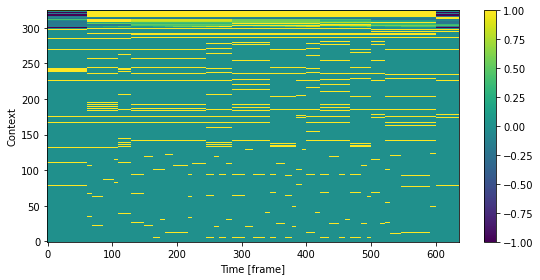

In [20]:
# 可視化用に正規化
in_feats = feats_frame / np.maximum(1, np.abs(feats_frame).max(0))
fig, ax = plt.subplots(figsize=(8,4))
mesh = ax.imshow(in_feats.T, aspect="auto", interpolation="none", origin="lower", cmap=cmap)
fig.colorbar(mesh, ax=ax)

ax.set_xlabel("Time [frame]")
ax.set_ylabel("Context")
plt.tight_layout()

## 5.5 音響特徴量の抽出

### 対数基本周波数

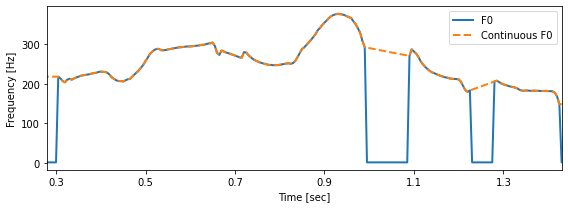

In [41]:
from scipy.io import wavfile
import pyworld
from nnmnkwii.preprocessing.f0 import interp1d

# 基本周波数を対数基本周波数へ変換する関数
def f0_to_lf0(f0):
    lf0 = f0.copy()
    nonzero_indices = np.nonzero(f0)
    lf0[nonzero_indices] = np.log(f0[nonzero_indices])
    return lf0

# 音声ファイルの読み込み
sr, x = wavfile.read(ttslearn.util.example_audio_file())
x = x.astype(np.float64)

# DIO による基本周波数推定
f0, timeaxis = pyworld.dio(x, sr)

# 基本周波数を対数基本周波数に変換
lf0 = f0_to_lf0(f0)

# 対数基本周波数に対して線形補間
clf0 = interp1d(lf0, kind="linear")

# 可視化
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(timeaxis, np.exp(lf0), linewidth=2, label="F0")
ax.plot(timeaxis, np.exp(clf0), "--", linewidth=2, label="Continuous F0")
ax.set_xlabel("Time [sec]")
ax.set_xticks(np.arange(0.3, 1.4, 0.2))
ax.set_xlim(0.28, 1.43)
ax.set_ylabel("Frequency [Hz]")
ax.legend()
plt.tight_layout()

# 図5-6
savefig("fig/dnntts_cf0")

### 有声/無声フラグ

/home/vscode/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: waveshow() keyword argument 'x_axis' has been renamed to 'axis' in version 0.10.0.
	This alias will be removed in version 1.0.
  if __name__ == "__main__":


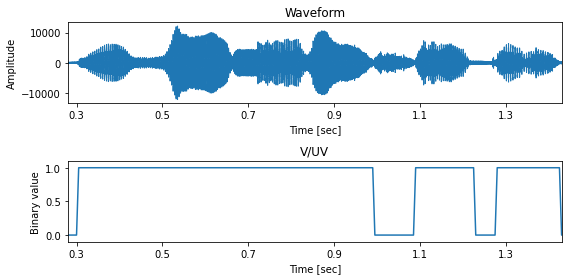

In [42]:
# DIO による基本周波数推定
f0, timeaxis = pyworld.dio(x, sr)

# 有声/無声フラグ の計算
vuv = (f0 > 0).astype(np.float32)

hop_length = int(sr * 0.005)
fig, ax = plt.subplots(2, 1, figsize=(8,4))
librosa.display.waveshow(x, sr=sr, x_axis="time", ax=ax[0])
ax[1].plot(timeaxis, vuv)
ax[1].set_ylim(-0.1, 1.1)

ax[0].set_title("Waveform")
ax[1].set_title("V/UV")
ax[0].set_xlabel("Time [sec]")
ax[0].set_ylabel("Amplitude")
ax[1].set_xlabel("Time [sec]")
ax[1].set_ylabel("Binary value")

for a in ax:
    a.set_xlim(0.28, 1.43)
    a.set_xticks(np.arange(0.3, 1.4, 0.2))
plt.tight_layout()

# 図5-7
savefig("fig/dnntts_vuv")

### メルケプストラム

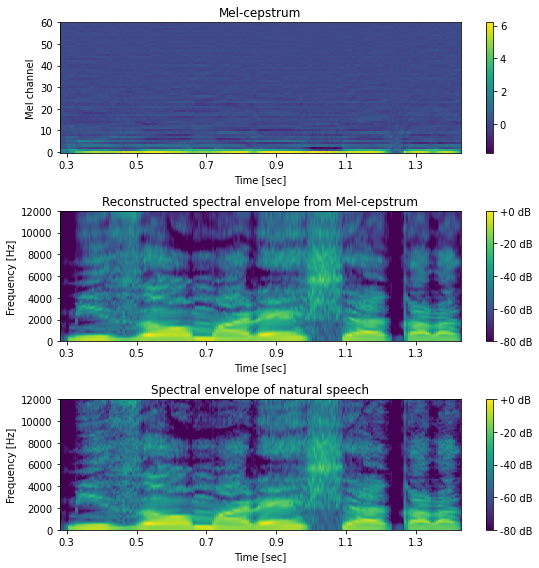

In [23]:
import pysptk

# DIO による基本周波数の推定
f0, timeaxis = pyworld.dio(x, sr)

# CheapTrick によるスペクトル包絡の推定
# 返り値は、パワースペクトルであることに注意 (振幅が 2 乗されている)
spectrogram = pyworld.cheaptrick(x, f0, timeaxis, sr)

# 線形周波数軸をメル周波数尺度に伸縮し、その後ケプストラムに変換
# alpha は周波数軸の伸縮のパラメータを表します
alpha = pysptk.util.mcepalpha(sr)
# FFT 長は、サンプリング周波数が 48kHz の場合は 2048
fftlen = pyworld.get_cheaptrick_fft_size(sr)
# メルケプストラムの次元数は、 mgc_order + 1 となります
# NOTE: メル一般化ケプストラム (Mel-generalized cepstrum) の頭文字を取り、
# 変数名を mgc とします
mgc_order = 59
mgc = pysptk.sp2mc(spectrogram, mgc_order, alpha)

# メルケプストラムから元のスペクトル包絡を復元
# スペクトルの次元数は、　fftlen//2 + 1 = 1025
spectrogram_reconstructed = pysptk.mc2sp(mgc, alpha, fftlen)

# 可視化
hop_length = int(sr * 0.005)
fig, ax = plt.subplots(3, 1, figsize=(8,8))
ax[0].set_title("Mel-cepstrum")
ax[1].set_title("Reconstructed spectral envelope from Mel-cepstrum")
ax[2].set_title("Spectral envelope of natural speech")

mesh = librosa.display.specshow(mgc.T, sr=sr, hop_length=hop_length, x_axis="time", cmap=cmap, ax=ax[0])
fig.colorbar(mesh, ax=ax[0])
ax[0].set_yticks(np.arange(mgc_order+2)[::10])

log_sp_reconstructed = librosa.power_to_db(np.abs(spectrogram_reconstructed), ref=np.max)
mesh = librosa.display.specshow(log_sp_reconstructed.T, sr=sr, hop_length=hop_length, x_axis="time", y_axis="hz", cmap=cmap, ax=ax[1])
fig.colorbar(mesh, ax=ax[1], format="%+2.f dB")

log_sp = librosa.power_to_db(np.abs(spectrogram), ref=np.max)
mesh = librosa.display.specshow(log_sp.T, sr=sr, hop_length=hop_length, x_axis="time", y_axis="hz", cmap=cmap, ax=ax[2])
fig.colorbar(mesh, ax=ax[2], format="%+2.f dB")

ax[1].set_ylim(0, 12000)
ax[2].set_ylim(0, 12000)

for a in ax:
    a.set_xlabel("Time [sec]")
    a.set_xlim(0.28, 1.43)
    a.set_xticks(np.arange(0.3, 1.4, 0.2))

ax[0].set_ylabel("Mel channel")
ax[1].set_ylabel("Frequency [Hz]")
ax[2].set_ylabel("Frequency [Hz]")

plt.tight_layout()

# 図5-8
savefig("fig/dnntts_mcep_reconstructed")

In [24]:
print("圧縮率:", spectrogram.shape[1]/mgc.shape[1])

圧縮率: 17.083333333333332


### 帯域非周期性指標

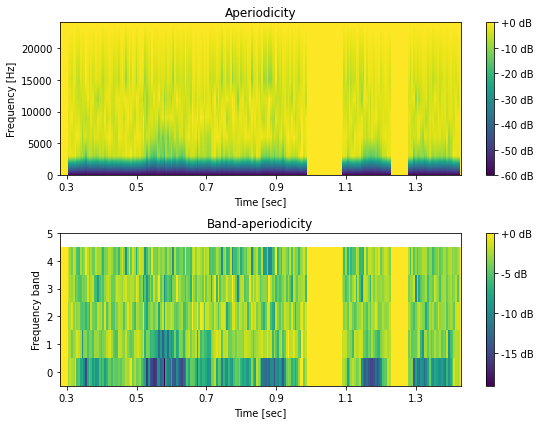

In [25]:
# DIO による基本周波数の推定
f0, timeaxis = pyworld.dio(x, sr)

# D4C による非周期性指標の推定
aperiodicity= pyworld.d4c(x, f0, timeaxis, sr)

# 帯域別の非周期性指標に圧縮
bap = pyworld.code_aperiodicity(aperiodicity, sr)

# 可視化
hop_length = int(sr * 0.005)
fig, ax = plt.subplots(2, 1, figsize=(8,6))
mesh = librosa.display.specshow(20*np.log10(aperiodicity).T, sr=sr, hop_length=hop_length, x_axis="time", y_axis="linear", cmap=cmap, ax=ax[0])
ax[0].set_title("Aperiodicity")
fig.colorbar(mesh, ax=ax[0], format="%+2.f dB")

mesh = librosa.display.specshow(bap.T, sr=sr, hop_length=hop_length, x_axis="time", cmap=cmap, ax=ax[1])
fig.colorbar(mesh, ax=ax[1], format="%+2.f dB")
ax[1].set_title("Band-aperiodicity")
for a in ax:
    a.set_xlabel("Time [sec]")
    a.set_ylabel("Frequency [Hz]")
    a.set_xlim(0.28, 1.43)
    a.set_xticks(np.arange(0.3, 1.4, 0.2))

ax[1].set_yticks(np.arange(5+1))
ax[1].set_ylabel("Frequency band")
plt.tight_layout()

# 図5-9
savefig("fig/dnntts_bap")

In [26]:
print("圧縮率:", aperiodicity.shape[1]/bap.shape[1])

圧縮率: 205.0


### 動的特徴量

In [27]:
def compute_delta(x, w):
    y = np.zeros_like(x)
    # 特徴量の次元ごとに動的特徴量を計算
    for d in range(x.shape[1]):
        y[:, d] = np.correlate(x[:, d], w, mode="same")
    return y

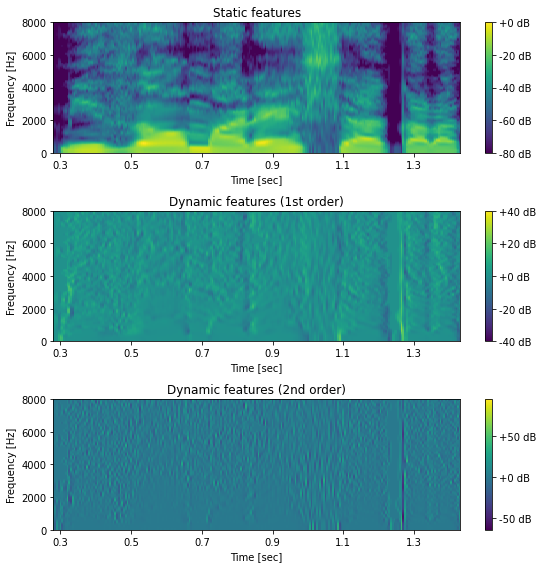

In [28]:
import librosa

# スペクトル包絡の推定
f0, timeaxis = pyworld.dio(x, sr)
spectrogram = pyworld.cheaptrick`(x, f0, timeaxis, sr)

# パワースペクトルを対数に変換
spectrogram = librosa.power_to_db(spectrogram, ref=np.max)

# 動的特徴量の計算
delta_window1 = [-0.5, 0.0, 0.5] # 1 次動的特徴量に対する窓
delta_window2 = [1.0, -2.0, 1.0] # 2 次動的特徴量に対する窓

# 1 次動的特徴量
delta = compute_delta(spectrogram, delta_window1)

# 2 次動的特徴量
deltadelta = compute_delta(spectrogram, delta_window2)

# スペクトル包絡に対して動的特徴量を計算して可視化
hop_length = int(sr * 0.005)
fig, ax = plt.subplots(3, 1, figsize=(8,8))
ax[0].set_title("Static features")
ax[1].set_title("Dynamic features (1st order)")
ax[2].set_title("Dynamic features (2nd order)")
mesh = librosa.display.specshow(spectrogram.T, sr=sr, hop_length=hop_length, x_axis="time", y_axis="hz", cmap=cmap, ax=ax[0])
fig.colorbar(mesh, ax=ax[0], format="%+2.f dB")
mesh = librosa.display.specshow(delta.T, sr=sr, hop_length=hop_length, x_axis="time", y_axis="hz", cmap=cmap, ax=ax[1])
fig.colorbar(mesh, ax=ax[1], format="%+2.f dB")
mesh = librosa.display.specshow(deltadelta.T, sr=sr, hop_length=hop_length, x_axis="time", y_axis="hz", cmap=cmap, ax=ax[2])
fig.colorbar(mesh, ax=ax[2], format="%+2.f dB")

for a in ax:
    a.set_xlabel("Time [sec]")
    a.set_ylabel("Frequency [Hz]")
    a.set_ylim(0, 8000)
    a.set_xlim(0.28, 1.43)
    a.set_xticks(np.arange(0.3, 1.4, 0.2))

plt.tight_layout()

# 図5-10
savefig("fig/dnntts_dynamic_features")

### 音響特徴量の結合

In [29]:
from nnmnkwii.preprocessing import delta_features

# WORLD による音声パラメータの推定
f0, timeaxis = pyworld.dio(x, sr)
spectrogram = pyworld.cheaptrick(x, f0, timeaxis, sr)
aperiodicity = pyworld.d4c(x, f0, timeaxis, sr)

# スペクトル包絡をメルケプストラムに変換
mgc_order = 59
alpha = pysptk.util.mcepalpha(sr)
mgc = pysptk.sp2mc(spectrogram, mgc_order, alpha)

# 有声/無声フラグの計算
vuv = (f0 > 0).astype(np.float32)

# 連続対数基本周波数系列
lf0 = interp1d(f0_to_lf0(f0), kind="linear")

# 帯域非周期性指標
bap = pyworld.code_aperiodicity(aperiodicity, sr)

# 基本周波数と有声/無声フラグを2次元の行列の形にしておく
lf0 = lf0[:, np.newaxis] if len(lf0.shape) == 1 else lf0
vuv = vuv[:, np.newaxis] if len(vuv.shape) == 1 else vuv

# 動的特徴量を計算するための窓
windows = [
    [1.0],  # 静的特徴量に対する窓
    [-0.5, 0.0, 0.5],  # 1次動的特徴量に対する窓
    [1.0, -2.0, 1.0],  # 2次動的特徴量に対する窓
]

# 静的特徴量と動的特徴量を結合した特徴量の計算
mgc = delta_features(mgc, windows)
lf0 = delta_features(lf0, windows)
bap = delta_features(bap, windows)

# すべての特徴量を結合した特徴量を作成
feats = np.hstack([mgc, lf0, vuv, bap])

print(f"メルケプストラムの次元数: {mgc.shape[1]}")
print(f"連続対数基本周波数の次元数: {lf0.shape[1]}")
print(f"有声 / 無声フラグの次元数: {vuv.shape[1]}")
print(f"帯域非周期性指標の次元数: {bap.shape[1]}")
print(f"結合された音響特徴量の次元数: {feats.shape[1]}")

メルケプストラムの次元数: 180
連続対数基本周波数の次元数: 3
有声 / 無声フラグの次元数: 1
帯域非周期性指標の次元数: 15
結合された音響特徴量の次元数: 199


## 5.6 音声波形の合成

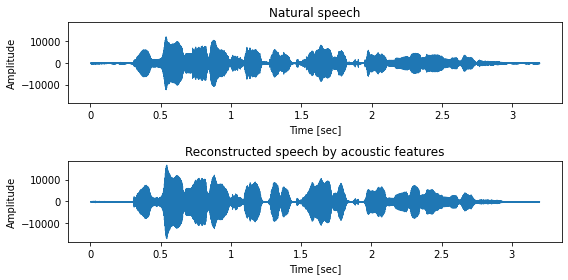

In [43]:
from nnmnkwii.paramgen import mlpg
from IPython.display import Audio
import IPython
from ttslearn.dnntts.multistream import get_windows, split_streams
from ttslearn.dsp import world_spss_params

# 音声ファイルの読み込み
sr, x = wavfile.read(ttslearn.util.example_audio_file())
x = x.astype(np.float64)

# 音響特徴量抽出のパラメータ
mgc_order = 59
alpha = pysptk.util.mcepalpha(sr)
fftlen = pyworld.get_cheaptrick_fft_size(sr)

# 音響特徴量の抽出
feats = world_spss_params(x, sr, mgc_order)

# パラメータ生成に必要な特徴量の分散
# 第6章で解説しますが、実際には学習データ全体に対して計算します
feats_var = np.var(feats, axis=1)

# 結合された特徴量から各特徴量の分離
stream_sizes = [(mgc_order + 1) * 3, 3, 1, pyworld.get_num_aperiodicities(sr) * 3]
mgc, lf0, vuv, bap = split_streams(feats, stream_sizes)

start_ind = np.hstack(([0], np.cumsum(stream_sizes)[:-1]))
end_ind = np.cumsum(stream_sizes)

# パラメータ生成に必要な、動的特徴量の計算に利用した窓
windows = get_windows(num_window=3)

# パラメータ生成
mgc = mlpg(mgc, feats_var[start_ind[0] : end_ind[0]], windows)
lf0 = mlpg(lf0, feats_var[start_ind[1] : end_ind[1]], windows)
bap = mlpg(bap, feats_var[start_ind[3] : end_ind[3]], windows)

# メルケプストラムからスペクトル包絡への変換
spectrogram = pysptk.mc2sp(mgc, alpha, fftlen)

# 連続対数基本周波数から基本周波数への変換
f0 = lf0.copy()
f0[vuv < 0.5] = 0
f0[np.nonzero(f0)] = np.exp(f0[np.nonzero(f0)])

# 帯域非周期指標から非周期性指標への変換
aperiodicity = pyworld.decode_aperiodicity(bap.astype(np.float64), sr, fftlen)

# WORLD による音声波形の合成
y = pyworld.synthesize(
    f0.flatten().astype(np.float64),
    spectrogram.astype(np.float64),
    aperiodicity.astype(np.float64),
    sr,
)

# オーディオプレイヤーの表示
IPython.display.display(Audio(x.astype(np.float32), rate=sr))
IPython.display.display(Audio(y.astype(np.float32), rate=sr))

# 可視化
fig, ax = plt.subplots(2, 1, figsize=(8, 4), sharey=True)
ax[0].set_title("Natural speech")
ax[1].set_title("Reconstructed speech by acoustic features")
librosa.display.waveshow(x.astype(np.float32), sr=sr, ax=ax[0])
librosa.display.waveshow(y.astype(np.float32), sr=sr, ax=ax[1])
for a in ax:
    a.set_xlabel("Time [sec]")
    a.set_ylabel("Amplitude")
plt.tight_layout()

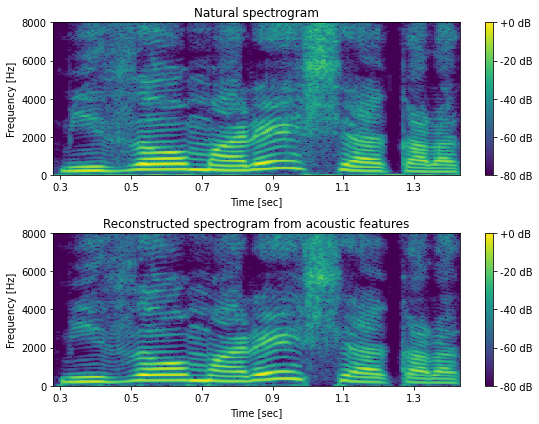

In [44]:
n_fft =  1024
frame_shift = int(sr * 0.005)
X = librosa.stft(x.astype(np.float32), n_fft=n_fft, win_length=n_fft, hop_length=frame_shift, window="hann")
logX = librosa.amplitude_to_db(np.abs(X), ref=np.max)
Y = librosa.stft(y.astype(np.float32), n_fft=n_fft, win_length=n_fft, hop_length=frame_shift, window="hann")
log_Y = librosa.amplitude_to_db(np.abs(Y), ref=np.max)

fig, ax = plt.subplots(2, 1, figsize=(8, 6))
ax[0].set_title("Natural spectrogram")
ax[1].set_title("Reconstructed spectrogram from acoustic features")

mesh = librosa.display.specshow(logX, sr=sr, hop_length=hop_length, x_axis="time", y_axis="hz", cmap=cmap, ax=ax[0])
fig.colorbar(mesh, ax=ax[0], format="%+2.f dB")
mesh = librosa.display.specshow(log_Y, sr=sr, hop_length=hop_length, x_axis="time", y_axis="hz", cmap=cmap, ax=ax[1])
fig.colorbar(mesh, ax=ax[1], format="%+2.f dB")

for a in ax:
    a.set_xlabel("Time [sec]")
    a.set_ylabel("Frequency [Hz]")
    a.set_ylim(0, 8000)
    a.set_xlim(0.28, 1.43)
    a.set_xticks(np.arange(0.3, 1.4, 0.2))

plt.tight_layout()

# 図5-13
savefig("fig/dnntts_waveform_reconstruction")